In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn.linear_model

In [14]:
x = np.array([[-0.86, -0.30, -0.05, 0.73]])
n = np.array([[5., 5., 5., 5.]])
y = np.array([[0, 1, 3, 5]])

Probabilistic model:

\begin{align*}
y_i | \theta_i &\sim  \mathrm{Bin}(n_i, \theta_i)\\
\rm{logit}(\theta_i) &= \alpha + \beta x_i\\
p(\alpha, \beta) &\propto 1
\end{align*}

In [19]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(x.transpose(), 1/5*y.reshape(-1))

ValueError: Unknown label type: 'continuous'

In [3]:
# Sigmoid is logit^{-1}
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [4]:
# Likelihood of the 4 observations. Overall likelihood is the product.
lik_fun = lambda alpha, beta: sigmoid(alpha+beta*x)**y * (1 - sigmoid(alpha+beta*x))**(n-y)

In [5]:
ALPHA = np.arange(-4, 10, 0.01)
BETA = np.arange(-10, 40, 0.01)

AA, BB = np.meshgrid(ALPHA, BETA, indexing='xy')
LL = lik_fun(AA[..., np.newaxis], BB[..., np.newaxis])
LL = np.prod(LL, axis=-1)

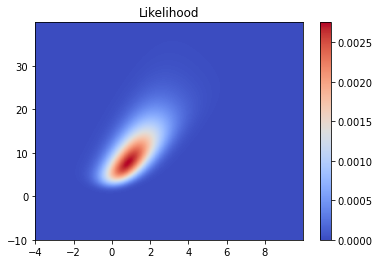

In [6]:
fig, ax = plt.subplots()
c = ax.pcolormesh(AA, BB, LL, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood");

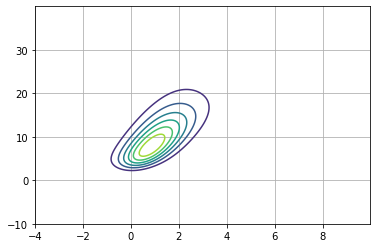

In [7]:
plt.contour(AA, BB, LL); #, levels=[5, 15,  95]); # levels=[5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
plt.grid(True)